In [2]:
"""Data acquisition module.

The sets of functions here help to gather the data from the source.

Authors: 
"""

import re
import numpy as np
from astropy.table import Table,vstack,groups,join

def cut(c):
    """Cut the data by a patron defined and return a tuple.

    Keyword arguments:
    data -- the data to cut, list
    
    """
    flag = True
    data = []
    head = []
    patron = re.compile("\s+")
    for i in c:
        if flag == True:
            head.append(patron.split(i))
            flag = False
        else:
            data.append(patron.split(i))
    return np.array(data),head

def parser(data):
    """Transform data from source txt to an structure and return a astropy.table.

    Keyword arguments:
    data -- the data to transform, list
    
    """
    c = []
    alpha = []
    gamma = []
    flag = 0
    flag1 = False
    typ= ('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8',np.str,'f8',np.str,np.str)
    for i in range(len(data)):
        flag1= re.findall("\# ######### LIGHT ",data[i])
        if flag1:
            data= data[i+1:]
            break
    for i in range(len(data)):
        head = re.findall("\A#\s+(.+)",data[i])
        new_line = re.findall("\A   (.+)",data[i]) 
        ra = re.findall("\#ra=\s+(.+)",data[i])
        dec = re.findall("\#dec=\s+(.+)",data[i])

        if ra:
            ra_aux = ra
        if dec:
            dec_aux = dec
        if head:
            [c.append(j) for j in head]
        if new_line:
            [c.append(k) for k in new_line]
            alpha.append(ra_aux)
            gamma.append(dec_aux)
            try:
                next_line = re.findall("\A   (.+)",data[i+1])
                if not next_line:
                    reg, col= cut(c)
                    if flag == 0:
                        col[0].append('RA')
                        col[0].append('DEC')
                        reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                        t = Table(reg, names=tuple(col[0]), dtype = typ)
                        c = []
                        alpha = []
                        gamma = []
                        flag += 1
                    else:
                        col[0].append('RA')
                        col[0].append('DEC')
                        reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                        t_aux = Table(reg, names=tuple(col[0]), dtype = typ)
                        t = vstack([t, t_aux])
                        c = []
                        alpha = []
                        gamma = []

            except:
                reg, col = cut(c)
                if flag == 0:
                    col[0].append('RA')
                    col[0].append('DEC')
                    reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                    t = Table(reg, names=tuple(col[0]), dtype = typ)
                    c = []
                    alpha = []
                    gamma = []
                    flag += 1   
                else:
                    col[0].append('RA')
                    col[0].append('DEC')
                    reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                    t_aux = Table(reg, names=tuple(col[0]), dtype = typ)
                    t = vstack([t, t_aux])
    file.close()

In [195]:
"""Preprocessing module.

The sets of functions here help from the perspective of preprocessing, complementing
the module of data gathering and features extraction.

Authors: 
"""

import numpy as np
import matplotlib.pyplot as plt
        
def outliers_iqr(data_col, aperture='0'):
    """Delete atypical data and return a astropy.table.

    Keyword argument:
    ys -- the data, {np.narray, astropy.table, astropy.table.column}
    aperture -- the aperture index, str
    
    """
    if (type(data_col)==Table):
        quartile_1, quartile_3 = np.percentile(data_col['MAG_'+aperture], [25,75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr*1.5)
        upper_bound = quartile_3 + (iqr*1.5)
        res = data_col[np.where((data_col['MAG_'+aperture] <= upper_bound) & (data_col['MAG_'+aperture] >= lower_bound))]
        res = join(res,data_col)
        
    else:
        quartile_1, quartile_3 = np.percentile(data_col, [25, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr*1.5)
        upper_bound = quartile_3 + (iqr*1.5)
        res = data_col[np.where((data_col <= upper_bound) & (data_col >= lower_bound))]
        if (type(data_col)==Table.Column):
            res = Table([res], names=(data_col.name,), dtype=('f8',))
            res.meta = data_col.meta
        else:
            res = Table([res], names=('MAG_'+'i', ))
    return res
        
def high_photometric_errors(data_col, aperture='0'):
    """Delete high photometric errors and return a astropy.table.

    Keyword argument:
    data -- the data to analyze, {np.narray, astropy.table, astropy.table.column}
    aperture -- the aperture index, str
    
    """
    if (type(data_col)==Table):    
        mer_mean = np.mean(data_col['MAG_'+aperture])
        mer_std = np.std(data_col['MAG_'+aperture])
        error_limit = mer_mean + 3*mer_std
        res = data_col[np.where(data_col['MAG_'+aperture] < error_limit)]
        res = join(res,data_col)
    else:
        mer_mean = np.mean(data_col)
        mer_std = np.std(data_col)
        error_limit = mer_mean + 3*mer_std
        res = data_col[np.where(data_col < error_limit)]
        if (type(data_col)==Table.Column):
            res = Table([res], names=(data_col.name,), dtype=('f8',))
            res.meta = data_col.meta
        else:
            res = Table([res], names=('MAG_'+'i', ))
    return res

# funcion que hace todo el preprocesamiento
def preprocessing(data,aperture):
    """Preprocess data for an aperture and return a astropy.table.

    Keyword arguments:
    data -- the data to analyze, {np.narray, astropy.table, astropy.table.column}
    aperture -- the aperture index, str
    
    """
    # 1 - se eliminan las mediciones con alto error fotometrico
    data_aux = high_photometric_errors(data,aperture)
    #2 - se eliminan datos atípicos
    data_aux = outliers_iqr(data_aux,aperture)
    # Se retornan los dias julianos y la magnitud de la apertura seleccionada
    return join(data, data_aux)


In [184]:
"""Features extraction module.

The objective of this module is analyze the preprocessed light curves.

Authors: 
"""

from scipy.optimize import curve_fit
import numpy as np

def lineal_fit(t,a,b):
    """Lineal fit to data and return param m np.narray.

    Keyword arguments:
    t -- A np.narray
    a -- A float
    b -- A float
    
    """
    m = a+b*t
    return m

def parabolic_fit(t,a,b,c):
    """Parabolic fit to data and return param m np.narray.

    Keyword arguments:
    t -- A np.narray
    a -- A float
    b -- A float
    c -- A float
    
    """
    m = a + b*t + c*t*t
    return m

# Por ahora fit puede ser lineal o parabolico
def get_statistics(t,y):
    """Obtain and return Q1', C1, Q2' and C2.

    Keyword arguments:
    t -- A np.narray, astropy.table.column
    y -- A np.narray, astropy.table.column
    
    """
    # Desviacion estandar y
    dep = np.std(y)
    #para fit lineal
    poptl, pcovl = curve_fit(lineal_fit, t, y)
    y_hatl = lineal_fit(t,*poptl)
    perrl = np.sqrt(np.diag(pcovl))
    defl = np.sqrt(np.sum((y_hatl- y)*(y_hatl- y))/len(y))
    q1 = poptl[1]/perrl[1]
    c1 = 1-(defl/dep)
    # Para fit parabolico
    poptp, pcovp = curve_fit(parabolic_fit, t, y)
    y_hatp = parabolic_fit(t,*poptp)
    perrp = np.sqrt(np.diag(pcovp))
    defp = np.sqrt(np.sum((y_hatp- y)*(y_hatp- y))/len(y))
    q2 = poptp[2]/perrp[2]
    c2 = 1-(defp/defl)
    stat = [q1,c1,q2,c2]
    return stat

def get_ra_dec(data):
    """Obtain and return RA and DEC, both str.
    
    RA is the Right Ascencion.
    DEC is the Declination.

    Keyword arguments:
    data -- the data to analyze, astropy.table
    
    """
    ra= data['RA'][0].split(" ")[0]
    dec= data['DEC'][0].split(" ")[0]
    return ra,dec


In [43]:
"""Filter module.

The objective of this module is to classify each star by his light curve's
params obtained from features extraction module, filtering by a group of 
thresholds the stars that are not periodic large variable.

Authors: 
"""

import numpy as np

def grade_filter(data,grades):
    """Filter the data to preprocess and return a astropy.table.

    Keyword arguments:
    data -- the data to analyze, astropy.table
    grades -- the grades to analyze, tuple
    
    """
    data_aux = Table([grades], names=['GRADE'])
    res = join(data, data_aux, join_type='right')
    if (len(res)) == 0:
        print("there's no values asociated with "+str(grades)+" apertures, no table returned")
        return -1
    if res.masked:
        del res[res['HJD'].mask.nonzero()[0]]
    return res

def stars_Cfilter(data, ThC1=0.02, ThC2=0.02):
    """Filter the data by thresholds and return the filtered data as astropy.table.
    
    ThreshC1 -- the threshold for C1
    ThreshC2 -- the threshold for C2
    
    """
    return data[np.where((data['C1']>=ThC1)&(data['C2']>=ThC2))]
    
def stars_Qfilter(data, ThQ1=4, ThQ2=4):
    """Filter the data by thresholds and return the filtered data as astropy.table.
    
    ThreshC1 -- the threshold for C1
    ThreshC2 -- the threshold for C2
    
    """
    return data[np.where((data['Q1']>=ThQ1)&(data['Q2']>=ThQ2))]


In [ ]:
""" Utilities

"""
    
def _Sort(tup):
    """Sort a tuple in descending order and return a tuple.

    Keyword arguments:
    tup -- tuple to sort, tuple
    
    """
    # reverse = True (Sorts in Descending order)
    return(sorted(tup, key = lambda x: float(x[0]), reverse = True))
        
def _graph(data,path,title):
    """Graph in a scatter type and save to a folder.

    Keyword arguments:
    data -- the data to graph, tuple
    path -- the path to save, str
    title -- the graph title, str
    
    """
    data = Sort(data)
    fig, ax = plt.subplots()
    ax.scatter(data[0],data[1])
    ax.set(xlabel='HJD', ylabel='Magnitude',
           title=title)
    ax.grid()
    fig.savefig(path+"/"+title+"_fig.png")
    
def grades():
    """Ask for grades to keyboard input and return a list with the keyboard input."""
    try:
        grades = input('Select GRADE, usage "A,B,..." with valid options A,B,C,D: ')
        if not(set(grades.split(",")) <= {'A','B','C','D'}):
            raise ValueError(grades)
        return grades.split(",")
    except ValueError:
        print("incorrect GRADE, ingressed: ",grades)
        raise
        
def mags():
    """Ask for magnitudes to keyboard input and return a tuple."""
    try:
        mags = input('Select MAG, usage MAG_2,MAG_0,MAG_1,MAG_3,MAG_4 like 0,0,1,0,0 for only MAG_1 with full weight: ')
        if (int(max(set(mags.split(",")))) > 1):
            raise ValueError(mags)
        return tuple(mags.split(","))
    except ValueError:
        print("incorrect MAG, ingressed: ",mags)
        raise

###########################Example function - blue box#############################
# usage: 
# path = directory path with data
# ThreshQ1, ThreshC1, ThreshQ2, ThreshC2 are the threshold used in final stage
# optional: when "stop" archives were opened -> stop, if 0 open all archives in path
def blue_box(path,ThreshQ1, ThreshC1, ThreshQ2, ThreshC2,stop=0):
    "Doc"
    grad = grades()
    mag = mags()
    counter = 0
    row= []
    col= ["ASAS NAME","RA","DEC","Q1","C1","Q2","C2"]
    
    for filename in os.listdir(path):
        file = open(path+filename,"r")
        text = file.readlines()
        df = parser(text)
        file.close()
        res = grade_filter(df,grad,mag)
        counter+=1
        #graph(res,"test",filename)
        stats = get_statistics(res[0],res[1])
        ra,dec= get_ra_dec(df)
        print(type(get_ra_dec(df)))
        row.append([filename,ra,dec,stats[0],stats[1],stats[2],stats[3]])
        
        if ((stop>0)&(stop==counter)):
            break
    data = pd.DataFrame(row,columns=col)
    data = stars_filter(data, ThreshQ1, ThreshC1, ThreshQ2, ThreshC2)
    return data

####################################################################################


In [206]:
file = open("data/170010-5102.2.lc","r")
data = file.readlines()
c = []
alpha = []
gamma = []
flag = 0
flag1 = False
typ= ('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8',np.str,'f8',np.str,np.str)
for i in range(len(data)):
    flag1= re.findall("\# ######### LIGHT ",data[i])
    if flag1:
        data= data[i+1:]
        break
for i in range(len(data)):
    head = re.findall("\A#\s+(.+)",data[i])
    new_line = re.findall("\A   (.+)",data[i])
    ra = re.findall("\#ra=\s+(.+)",data[i])
    dec = re.findall("\#dec=\s+(.+)",data[i])

    if ra:
        ra_aux = ra
    if dec:
        dec_aux = dec
    if head:
        [c.append(j) for j in head]
    if new_line:
        [c.append(k) for k in new_line]
        alpha.append(ra_aux)
        gamma.append(dec_aux)
        try:
            next_line = re.findall("\A   (.+)",data[i+1])
            if not next_line:
                reg, col= cut(c)
                if flag == 0:
                    col[0].append('RA')
                    col[0].append('DEC')
                    reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                    t = Table(reg, names=tuple(col[0]), dtype = typ)
                    c = []
                    alpha = []
                    gamma = []
                    flag += 1
                else:
                    col[0].append('RA')
                    col[0].append('DEC')
                    reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                    t_aux = Table(reg, names=tuple(col[0]), dtype = typ)
                    t = vstack([t, t_aux])
                    c = []
                    alpha = []
                    gamma = []

        except:
            reg, col = cut(c)
            if flag == 0:
                col[0].append('RA')
                col[0].append('DEC')
                reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                t = Table(reg, names=tuple(col[0]), dtype = typ)
                c = []
                alpha = []
                gamma = []
                flag += 1   
            else:
                col[0].append('RA')
                col[0].append('DEC')
                reg = np.c_[reg,np.array(alpha),np.array(gamma)]
                t_aux = Table(reg, names=tuple(col[0]), dtype = typ)
                t = vstack([t, t_aux])
file.close()

In [208]:
print(t)

   HJD     MAG_2  MAG_0  ...           RA                   DEC          
---------- ------ ------ ... --------------------- ----------------------
1958.89688 10.764 10.808 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2031.72434 10.949 11.042 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
 2035.6746 29.999 29.999 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2054.68488 10.875  10.98 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2059.71026 10.821 10.904 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2087.60202 10.725 10.756 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
  2093.531 10.707 10.668 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2102.55559 10.716 10.745 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2104.57737 10.691 10.733 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
2106.57625 10.733   10.8 ... 17.002834  17:00:10.2 -51.036509 -51:02:11.4
       ...    ...    ... ...                   ...                    ...
2860.54077 10.619 10.694 ... 19.445185

In [201]:
t_aux[np.where((t_aux['MAG_0'] > 10.8)&(t_aux['MER_0'] < 0.05))]

HJD,MAG_0,MER_0,RA,DEC
float64,float64,float64,str24,str24
1954.84146,10.804,0.042,19.445185 19:26:42.7,-58.368007 -58:22:04.8
2830.74059,10.914,0.049,17.002834 17:00:10.2,-51.036509 -51:02:11.4


In [191]:
type(t['MAG_0'])

astropy.table.column.Column

<IPython.core.display.Javascript object>


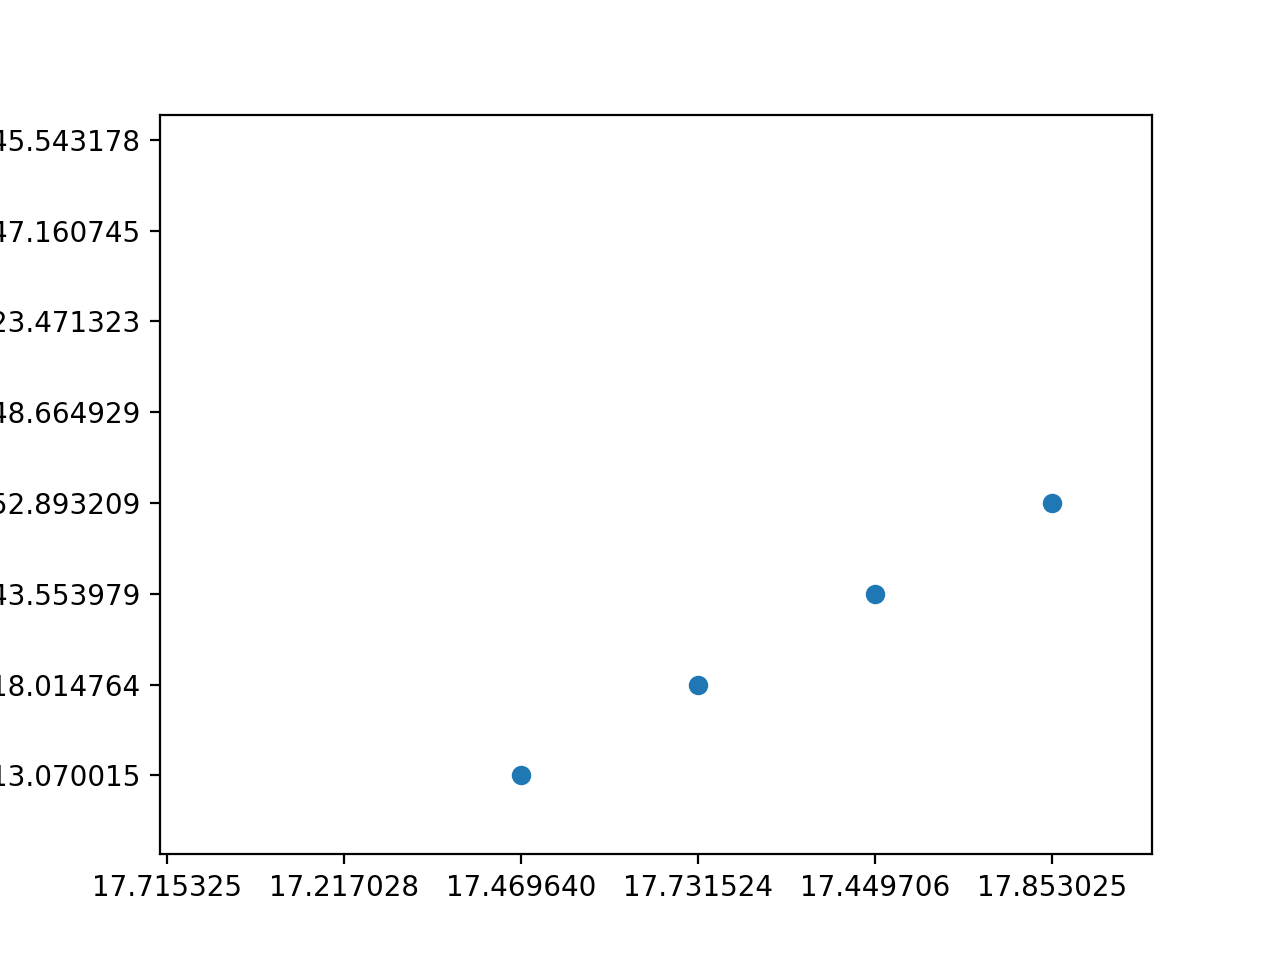

In [26]:
%matplotlib notebook
import seaborn as sns
#sns.pairplot(res[['RA','DEC']])
import matplotlib.pyplot as plt
plt.scatter(res['RA'],res['DEC'])
plt.show()

In [129]:
data = t
# 1 - se eliminan las mediciones con alto error fotometrico
data_aux = high_photometric_errors(data["MER_2"])
#2 - se eliminan datos atípicos
data_aux = outliers_iqr(data_aux)
# Se retornan los dias julianos y la magnitud de la apertura seleccionada
reg =  join()
t = Table(reg, names=('HJD','MAG'+aperture), dtype = ('f8','f8'))
reg

TypeError: join() missing 2 required positional arguments: 'left' and 'right'

In [20]:
def grade_filter(table, key_colnames):
    colnames = [name for name in table.colnames if name not in key_colnames]
    for colname in colnames:
        if np.any(table[colname] < 0):
            return False
    return True


False

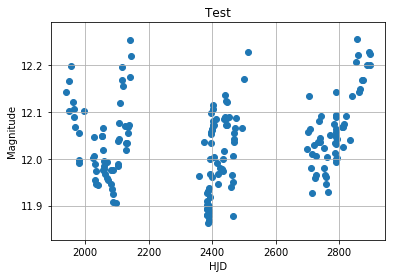

In [128]:
import matplotlib
import matplotlib.pyplot as plt

def Sort(tup): 
    # reverse = True (Sorts in Descending order) 
    # key is set to sort using float elements 
    # lambda has been used 
    return(sorted(tup, key = lambda x: float(x[0]), reverse = True)) 
res = Sort(res)

fig, ax = plt.subplots()
ax.scatter(res[0],res[1])

ax.set(xlabel='HJD', ylabel='Magnitude',
       title='Test')
ax.grid()

fig.savefig("test/test"+str(counter)+".png")
plt.show()


In [182]:
np.array(alpha)

array([['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.445185  19:26:42.7'],
       ['19.44

In [207]:
t = Table(np.c_[rows,np.array(alpha),np.array(gamma)], names=tuple(col[0],'RA','DEC'), dtype = ('f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','S1','f8'))


TypeError: tuple() takes at most 1 argument (3 given)

In [222]:
col[0]

['HJD',
 'MAG_2',
 'MAG_0',
 'MAG_1',
 'MAG_3',
 'MAG_4',
 'MER_2',
 'MER_0',
 'MER_1',
 'MER_3',
 'MER_4',
 'GRADE',
 'FRAME',
 'RA',
 'DEC']

In [205]:
data = [ '#nskip_4= 0\n',
 '#ra=   17.000018  17:00:00.1\n',
 '#dec= -24.121600 -24:07:17.8\n',
 '#     HJD      MAG_1  MAG_0  MAG_2  MAG_3  MAG_4    MER_1 MER_0 MER_2 MER_3 MER_4 GRADE FRAME\n',
 '   2140.48752 12.253 12.299 12.194 12.162 12.187    0.020 0.038 0.017 0.018 0.021  A 30120\n',
 '   2384.87500 11.893 11.977 11.846 11.806 11.814    0.018 0.034 0.019 0.021 0.024  A 773\n',
 '   2385.89474 11.916 12.083 11.843 11.807 11.784    0.034 0.057 0.032 0.034 0.040  D 984\n']
res = parser(data)
print(res)

None


In [1]:
from astropy.table import Table
a = [1, 4, 5]
b = [2.0, 5.0, 8.2]
c = ['x', 'y', 'z']
t = Table([a, b, c], names=('a', 'b', 'c'), meta={'name': 'first table'})

In [212]:
Table.read("""    HJD      MAG_1  MAG_0  MAG_2  MAG_3  MAG_4    MER_1 MER_0 MER_2 MER_3 MER_4 GRADE FRAME\n
    2140.48752 12.253 12.299 12.194 12.162 12.187    0.020 0.038 0.017 0.018 0.021  A 30120\n
    2384.87500 11.893 11.977 11.846 11.806 11.814    0.018 0.034 0.019 0.021 0.024  A 773\n
    2385.89474 11.916 12.083 11.843 11.807 11.784    0.034 0.057 0.032 0.034 0.040  D 984\n""", format='ascii')

HJD,MAG_1,MAG_0,MAG_2,MAG_3,MAG_4,MER_1,MER_0,MER_2,MER_3,MER_4,GRADE,FRAME
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,int64
2140.48752,12.253,12.299,12.194,12.162,12.187,0.02,0.038,0.017,0.018,0.021,A,30120
2384.875,11.893,11.977,11.846,11.806,11.814,0.018,0.034,0.019,0.021,0.024,A,773
2385.89474,11.916,12.083,11.843,11.807,11.784,0.034,0.057,0.032,0.034,0.04,D,984
